In [2]:
%matplotlib inline


Spatial Transformer Networks Tutorial
=====================================
**Author**: `Ghassen HAMROUNI <https://github.com/GHamrouni>`_

.. figure:https://ptorch.com/uploads/2018031116515742548.jpg

In this tutorial, you will learn how to augment your network using
a visual attention mechanism called spatial transformer
networks. You can read more about the spatial transformer
networks in the `DeepMind paper <https://arxiv.org/abs/1506.02025>`__

Spatial transformer networks are a generalization of differentiable
attention to any spatial transformation. Spatial transformer networks
(STN for short) allow a neural network to learn how to perform spatial
transformations on the input image in order to enhance the geometric
invariance of the model.
For example, it can crop a region of interest, scale and correct
the orientation of an image. It can be a useful mechanism because CNNs
are not invariant to rotation and scale and more general affine
transformations.

One of the best things about STN is the ability to simply plug it into
any existing CNN with very little modification.



In [3]:
# License: BSD
# Author: Ghassen Hamrouni

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

Loading the data
----------------

In this post we experiment with the classic MNIST dataset. Using a
standard convolutional network augmented with a spatial transformer
network.



In [4]:
# 判断设备是否支持GPU运算
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=False,
                   transform=transforms.Compose([#将多个步骤进行整合
                       transforms.ToTensor(),#归整到0-1之间
                       transforms.Normalize((0.1307,), (0.3081,))#给定均值(R, G, B)和标准差(R, G, B)，用公式channel = (channel - mean) / std进行规范化
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

Depicting spatial transformer networks
--------------------------------------

Spatial transformer networks boils down to three main components :

-  The localization network is a regular CNN which regresses the
   transformation parameters. The transformation is never learned
   explicitly from this dataset, instead the network learns automatically
   the spatial transformations that enhances the global accuracy.
-  The grid generator generates a grid of coordinates in the input
   image corresponding to each pixel from the output image.
-  The sampler uses the parameters of the transformation and applies
   it to the input image.

.. figure:https://pytorch.org/tutorials/_images/stn-arch.png

.. Note::
   We need the latest version of PyTorch that contains
   affine_grid and grid_sample modules.




In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5)
        self.conv2 = nn.Conv2d(4, 6, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(96, 20)
        self.fc2 = nn.Linear(20, 10)

        # Spatial transformer localization-network 空间变换的定位网络
        # Sequential是一个容器类，我们可以在它里面添加一些基本的模块
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        # 相当于仿射矩阵theta
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 10),
            nn.ReLU(True),
            nn.Linear(10, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        #print('xs.size():',xs.size())#xs.size(): torch.Size([64, 10, 3, 3])
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        #进行仿射变换操作
        grid = F.affine_grid(theta, x.size()) #Grid generator
        x = F.grid_sample(x, grid) # Sampler: 裁剪feature map

        return x

    def forward(self, x):
        # transform the input
        # 进行STN操作
        x = self.stn(x)

        # Perform the usual forward pass
        # 执行常规的CNN
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print('x.size():',x.size())#x.size(): torch.Size([64, 6, 4, 4])
        x = x.view(-1, 96)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #print('F.log_softmax(x, dim=1).size():',F.log_softmax(x, dim=1).size())#x.size(): torch.Size([64, 6, 4, 4])
        return F.log_softmax(x, dim=1)
model = Net().to(device)#方便代码进行移植，无论设备是否支持CUDA都可以运算    

In [6]:
print(model)

Net(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=96, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=90, out_features=10, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=10, out_features=6, bias=True)
  )
)


Training the model
------------------

Now, let's use the SGD algorithm to train the model. The network is
learning the classification task in a supervised way. In the same time
the model is learning STN automatically in an end-to-end fashion.



In [7]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    
    #训练模型时使用，框架会自动把BN和DropOut固定住，不会取平均，而是用训练好的值，不然的话，
    #一旦test的batch_size过小，很容易就会被BN层导致生成图片颜色失真极大！
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        #print('data.size():',data.size())#data.size(): torch.Size([64, 1, 28, 28])

        optimizer.zero_grad()
        
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        '''
        Train Epoch: 1 [0/60000 (0%)]	Loss: 2.339511
        Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.010228
        '''   
        
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    
    # torch.no_grad() impacts the autograd engine and deactivate it. 
    # It will reduce memory usage and speed up computations
    with torch.no_grad(): #关闭反向传播中的自动求导功能，减少内存损耗
        
        #与model.train()对应用于测试阶段，model.eval() will notify all your layers that you are in eval mode,
        # that way, batchnorm or dropout layers will work in eval model instead of training mode.
        model.eval()  
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]#只返回每行最大值的每个索引
            correct += pred.eq(target.view_as(pred)).sum().item()#统计相等的个数

        test_loss /= len(test_loader.dataset)#计算平均的损失
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))
        '''
        Test set: Average loss: 1.0267, Accuracy: 6721/10000 (67%)
        '''

Visualizing the STN results
---------------------------

Now, we will inspect the results of our learned visual attention
mechanism.

We define a small helper function in order to visualize the
transformations while training.



In [8]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    #print(inp.size())#torch.Size([3, 242, 242])
    inp = inp.numpy().transpose((1, 2, 0))#做转置操作,inp.size=(242, 242, 3)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean#inp.size=(242, 242, 3)   
    inp = np.clip(inp, 0, 1)# 限制元素大小到0-1之间
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():#关闭反向传播中的自动求导功能，减少内存损耗
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)
        #print(data.size())#torch.Size([64, 1, 28, 28])

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()#执行STN网络
        #print(transformed_input_tensor.size())#torch.Size([64, 1, 28, 28])

        #执行STN空间变换网络之前         
        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))
        #print(input_tensor.size())#torch.Size([64, 1, 28, 28])
        #print(torchvision.utils.make_grid(input_tensor).size())#torch.Size([3, 242, 242])
        #print(len(in_grid))#242

        #执行STN空间变换网络之后
        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))
        #print(torchvision.utils.make_grid(transformed_input_tensor).size())#torch.Size([3, 242, 242])

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

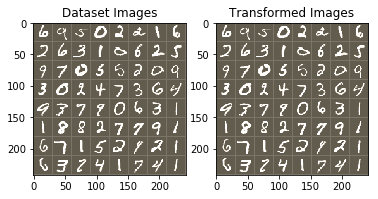

In [9]:
# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

In [10]:
for epoch in range(1, 20):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312885
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.878559

Test set: Average loss: 0.8117, Accuracy: 7847/10000 (78%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.302117
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.970594

Test set: Average loss: 0.3629, Accuracy: 9114/10000 (91%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.697347
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.751118

Test set: Average loss: 0.2860, Accuracy: 9154/10000 (92%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.134387
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.552603

Test set: Average loss: 0.2444, Accuracy: 9324/10000 (93%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.687864
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.598914

Test set: Average loss: 0.1673, Accuracy: 9544/10000 (95%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.541376
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.835635

Test set: Average loss: 0.1433, Accuracy: 9566/10000 (96%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.517301
Train Epoch: 7 [320